In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## goal: we want to find patterns in train.csv that help us predict whether the passengers in test.csv survived.

In [2]:
# read all datasets
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
gender_data = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
train_data.head()
# gender_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# add family_size feature
train_data["family_size"] = train_data["SibSp"] + train_data["Parch"]
test_data["family_size"] = test_data["SibSp"] + test_data["Parch"]

# count missing vals for both train and test
count_missing_vals = train_data.isnull().sum()
print(count_missing_vals)
print("\n\n")
count_missing_vals = test_data.isnull().sum()
print(count_missing_vals)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
family_size      0
dtype: int64



PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
family_size      0
dtype: int64


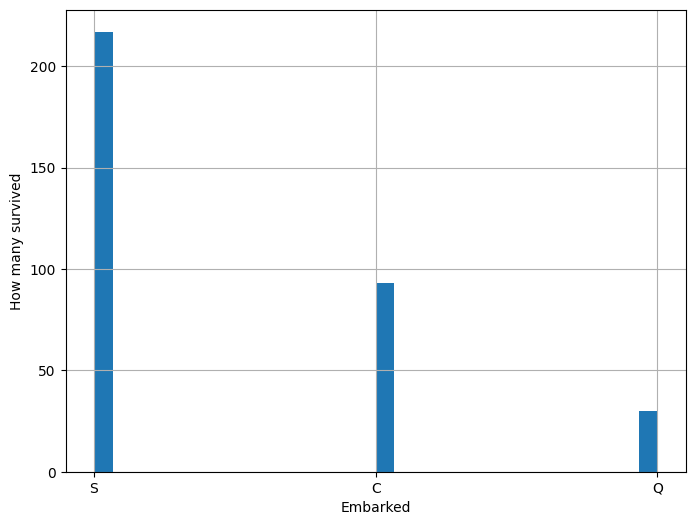

In [4]:
# Embarked vs survived
train_data.dropna(subset=['Embarked'], inplace=True)
plt.figure(figsize=(8,6))
plt.hist(train_data["Embarked"], 
         bins=30, 
         weights=train_data['Survived'])
plt.xlabel('Embarked')
plt.ylabel('How many survived')
plt.grid(True)
plt.show()

# seems like people who departed from 'S' survived more than the others

In [5]:
# fill missing age values with mean for both train and test datasets
train_mean_age = round(train_data["Age"].mean())
train_data.fillna({"Age": train_mean_age}, inplace=True)

test_mean_age = round(test_data["Age"].mean())
test_data.fillna({"Age": test_mean_age}, inplace=True)

# change Sex (Categorical) to Numerical for train and test
pd.set_option('future.no_silent_downcasting', True) # need this or else Downcasting behavior
train_data.replace({"Sex": {"female": 1, "male": 0}}, inplace=True)
test_data.replace({"Sex": {"female": 1, "male": 0}}, inplace=True)

train_data["Sex"] = train_data["Sex"].astype(int)
test_data["Sex"] = test_data["Sex"].astype(int)

# scale fare and add it as a feature
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_data['Fare'] = scaler.fit_transform(train_data[['Fare']])
test_data['Fare'] = scaler.fit_transform(test_data[['Fare']])

# fill NaN for test data Fare
test_data.fillna({"Fare": round(test_data['Fare'].mean())}, inplace=True)

In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,family_size
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,2.311586,0.350956,29.713352,0.524184,0.382452,0.062649,0.906637
std,256.998173,0.486260,0.834700,0.477538,12.969135,1.103705,0.806761,0.097003,1.614703
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,0.015412,0.000000
50%,446.000000,0.000000,3.000000,0.000000,30.000000,0.000000,0.000000,0.028213,0.000000
75%,668.000000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,0.060508,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,1.000000,10.000000


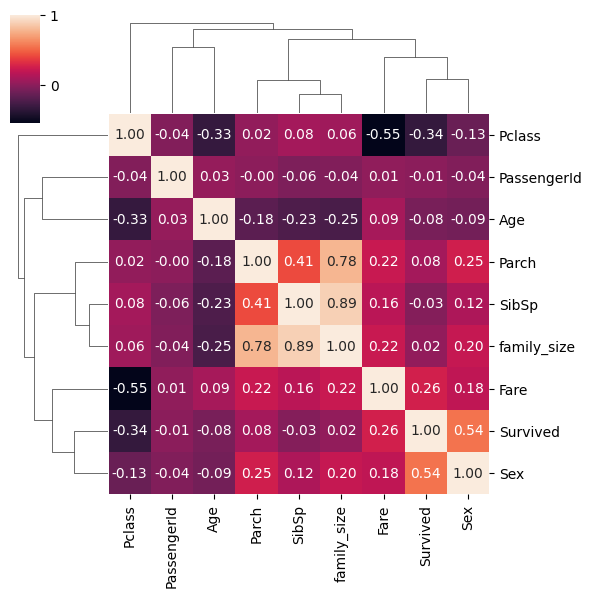

In [7]:
# filter train_data for numeric values to conduct numeric data analysis
num_train_data = train_data.select_dtypes(include=['number'])
train_corr_matrix = num_train_data.corr()

# plot clustermap to see linkages and correlation vals
mask = np.triu(np.ones_like(train_corr_matrix))
sns.clustermap(train_corr_matrix,
               annot=True,
              fmt='.2f',
              figsize=(6,6))